# Convnets
Previously, we tested different model with the set of high-level features extracted from the pretrained neural network __Inception V3__. Here, I will try to create my own ConvNet from scratch using the pixel values from the original images to train the model. Since I have a small dataset to train, I'll try to use Data augmentation (rescaling, horizontal_flip ...) in order to better catch the different images.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd

# Create image generator
train_generator = ImageDataGenerator(rescale=1/255,
                                    rotation_range = 40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_generator = ImageDataGenerator(rescale=1/255)
# Create an iterator that iterates over the directory

# Train, validation and test sets
trainset = train_generator.flow_from_directory(
    os.path.join('swissroads', 'train'), target_size=(299, 299),
    shuffle=True, class_mode = 'categorical', batch_size = 280)
validset = train_generator.flow_from_directory(
    os.path.join('swissroads', 'valid'), target_size=(299, 299),
    shuffle=False, class_mode = 'categorical', batch_size = 280)
testset = test_generator.flow_from_directory(
    os.path.join('swissroads', 'test'), target_size=(299, 299),
    shuffle=False, class_mode = 'categorical', batch_size = 280)

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


Now I'll try to build my convolutional Network using three convolutional layers, three pooling layers, and one Dropout for regularization. The reason is just because I have read somewhere on internet that this sequence could be good for small datasets. Actually, I really don't know how to improve this neural network other than by trial and errors. I tried several networks and this one seemed to perform the best, although (spoiler alert) it is not that good. During the course, I haven't learn how to improve my model. I guess it was juste an introductory course to understand how convolutional networks actually work.

In [2]:
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models

# Convolutional Network
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                              activation='relu', input_shape=(299, 299, 3)))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

# Dense layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=trainset.num_classes, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])

# End training when accuracy stops improving (optional)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0         
__________

In [3]:
# Train model
history = model.fit_generator(
    generator=trainset, validation_data=validset, epochs=20, callbacks=[early_stopping], verbose=1)

Epoch 1/20
1/1 [==============================] - 67s 67s/step - loss: 1.7942 - acc: 0.1607 - val_loss: 1.9576 - val_acc: 0.2374
Epoch 2/20
1/1 [==============================] - 57s 57s/step - loss: 2.3206 - acc: 0.2286 - val_loss: 2.1387 - val_acc: 0.1799
Epoch 3/20
1/1 [==============================] - 58s 58s/step - loss: 2.2453 - acc: 0.1607 - val_loss: 1.7933 - val_acc: 0.1511
Epoch 4/20
1/1 [==============================] - 59s 59s/step - loss: 1.8226 - acc: 0.1679 - val_loss: 1.7682 - val_acc: 0.3237
Epoch 5/20
1/1 [==============================] - 56s 56s/step - loss: 1.7990 - acc: 0.2143 - val_loss: 1.7680 - val_acc: 0.2446
Epoch 6/20
1/1 [==============================] - 56s 56s/step - loss: 1.7878 - acc: 0.2107 - val_loss: 1.7683 - val_acc: 0.2446
Epoch 7/20
1/1 [==============================] - 54s 54s/step - loss: 1.7724 - acc: 0.2536 - val_loss: 1.7677 - val_acc: 0.2662
Epoch 8/20
1/1 [==============================] - 55s 55s/step - loss: 1.7642 - acc: 0.2536 - val

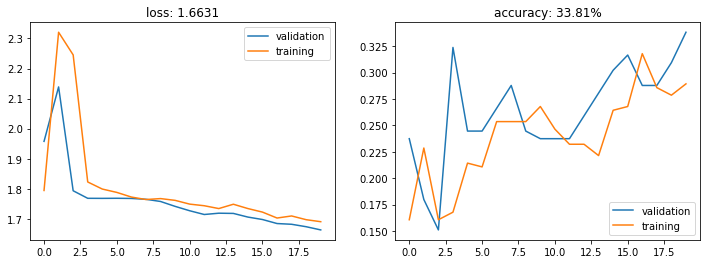

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(history.history['val_loss'][-1]))
ax1.plot(history.history['val_loss'], label='validation')
ax1.plot(history.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(history.history['val_acc'][-1]*100))
ax2.plot(history.history['val_acc'], label='validation')
ax2.plot(history.history['acc'], label='training')
ax2.legend()

plt.show()

In [5]:
test_loss, test_acurracy = model.evaluate_generator(testset)
print('Test loss: {:.2f}, accuracy: {:.2f}%'.format(test_loss, test_acurracy*100))

Test loss: 1.67, accuracy: 36.00%


After a few tries of different models, even my best model predicts poorly the class of the images, reaching an accuracy of ~30% on the validation set. This is due to several reasons:
- CNN works well only when we have sufficiently large data. Traditional CNN architecture need large number of parameters and a huge dataset. If we supply small data to a model having a large number of parameters the model will fail to learn the patterns and thus it gets easily overfitted. We can use several techniques to counter the problem with small datasets such as data augmentation and learning transfert. In this section, I tried with data augmentation, but augmentation will not increase the real world variability. (There is a difference between seeing 100 samples of the same class and 100 variations of a single sample). Ex: Seeing 100 Images of cat and 100 variations of single cat image. Augmentation will help just to make the model invariant to (rotation, flips etc)transformation. Learning Transfert however could really help us in this case. As we saw on the previous notebook.
- The images are similar. They are all vehicles with wheels, in an urban environment (roads, building ...) and it is difficult to distinguish them. 
- Pretrained model have been prepared on millions of images and by experts. It is thus normal that it gives better results.


In [6]:
# Store the accuracy
cnn_test_score = pd.DataFrame(data = {'model': ["cnn"], 'test_accuracy': [test_acurracy]})
%store cnn_test_score

Stored 'cnn_test_score' (DataFrame)
